[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/keras-team/autokeras/blob/master/docs/templates/tutorial/image_classification.ipynb)

In [2]:
import tensorflow as tf
import autokeras as ak
tf.__version__, ak.__version__

('2.3.1', '1.0.11')

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[6], 'GPU')

### Load california dataset

In [4]:
from sklearn.datasets import fetch_california_housing

house_dataset = fetch_california_housing()

# Import pandas package to format the data
import pandas as pd

# Extract features with their names into the a dataframe format
data = pd.DataFrame(house_dataset.data, columns=house_dataset.feature_names)

# Extract target with their names into a pd.Series object with name MEDV
target = pd.Series(house_dataset.target, name = 'MEDV')

from sklearn.model_selection import train_test_split
train_data, test_data, train_targets, test_targets = train_test_split(data, target, test_size=0.2, random_state=42)

In [5]:
# Check the shape of whole dataset and the splited training and test set
print("--Shape of the whole data--\n {}".format(data.shape))
print("\n--Shape of the target vector--\n {}".format(target.shape))
print("\n--Shape of the training data--\n {}".format(train_data.shape))
print("\n--Shape of the testing data--\n {}".format(test_data.shape))

--Shape of the whole data--
 (20640, 8)

--Shape of the target vector--
 (20640,)

--Shape of the training data--
 (16512, 8)

--Shape of the testing data--
 (4128, 8)


### Tuning MLP for structured-data regression  (CategoricalToNumerical + DenseBlock)

In [18]:
input_node = ak.StructuredDataInput()
output_node = ak.CategoricalToNumerical()(input_node)
output_node = ak.Normalization()(input_node)
output_node = ak.DenseBlock()(output_node)
output_node = ak.RegressionHead()(output_node)
auto_model = ak.AutoModel(inputs=input_node, outputs=output_node, max_trials=10, overwrite=True)

auto_model.fit(train_data, train_targets, batch_size=1024, epochs=150) # , epochs=150, verbose=2


Trial 10 Complete [00h 00m 38s]
val_loss: 0.29025542736053467

Best val_loss So Far: 0.29025542736053467
Total elapsed time: 00h 09m 54s
INFO:tensorflow:Oracle triggered exit
Epoch 1/150
17/17 [==============================] - 0s 15ms/step - loss: 5.4321 - mean_squared_error: 5.4321
Epoch 2/150
17/17 [==============================] - 0s 15ms/step - loss: 3.6908 - mean_squared_error: 3.6908
Epoch 3/150
17/17 [==============================] - 0s 14ms/step - loss: 1.7569 - mean_squared_error: 1.7569
Epoch 4/150
17/17 [==============================] - 0s 16ms/step - loss: 0.9042 - mean_squared_error: 0.9042
Epoch 5/150
17/17 [==============================] - 0s 16ms/step - loss: 0.7128 - mean_squared_error: 0.7128
Epoch 6/150
17/17 [==============================] - 0s 15ms/step - loss: 0.5947 - mean_squared_error: 0.5947
Epoch 7/150
17/17 [==============================] - 0s 15ms/step - loss: 0.4994 - mean_squared_error: 0.4994
Epoch 8/150
17/17 [==============================] - 0s

17/17 [==============================] - 0s 16ms/step - loss: 0.2430 - mean_squared_error: 0.2430
Epoch 74/150
17/17 [==============================] - 0s 15ms/step - loss: 0.2427 - mean_squared_error: 0.2427
Epoch 75/150
17/17 [==============================] - 0s 15ms/step - loss: 0.2425 - mean_squared_error: 0.2425
Epoch 76/150
17/17 [==============================] - 0s 17ms/step - loss: 0.2419 - mean_squared_error: 0.2419
Epoch 77/150
17/17 [==============================] - 0s 17ms/step - loss: 0.2413 - mean_squared_error: 0.2413
Epoch 78/150
17/17 [==============================] - 0s 16ms/step - loss: 0.2415 - mean_squared_error: 0.2415
Epoch 79/150
17/17 [==============================] - 0s 16ms/step - loss: 0.2414 - mean_squared_error: 0.2414
Epoch 80/150
17/17 [==============================] - 0s 18ms/step - loss: 0.2407 - mean_squared_error: 0.2407
Epoch 81/150
17/17 [==============================] - 0s 15ms/step - loss: 0.2407 - mean_squared_error: 0.2407
Epoch 82/150
1

17/17 [==============================] - 0s 16ms/step - loss: 0.2247 - mean_squared_error: 0.2247
Epoch 147/150
17/17 [==============================] - 0s 15ms/step - loss: 0.2247 - mean_squared_error: 0.2247
Epoch 148/150
17/17 [==============================] - 0s 19ms/step - loss: 0.2247 - mean_squared_error: 0.2247
Epoch 149/150
17/17 [==============================] - 0s 16ms/step - loss: 0.2247 - mean_squared_error: 0.2247
Epoch 150/150
17/17 [==============================] - 0s 16ms/step - loss: 0.2247 - mean_squared_error: 0.2247
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


In [19]:
test_loss, test_acc = auto_model.evaluate(test_data, test_targets, verbose=0)
print('Test accuracy: ', test_acc)

Test accuracy:  0.2667323648929596


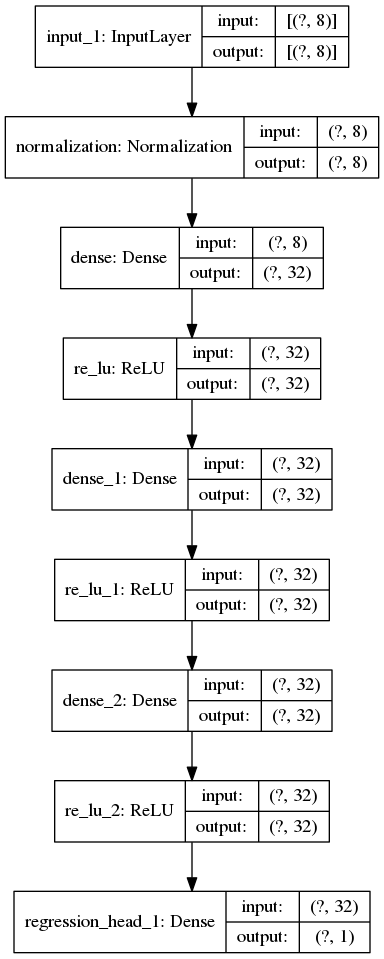

In [20]:
best_model = auto_model.export_model()
tf.keras.utils.plot_model(best_model, show_shapes=True, expand_nested=True) # rankdir='LR'

### Customize the search space for tuning MLP

In [22]:
from kerastuner.engine import hyperparameters as hp

input_node = ak.StructuredDataInput()
output_node = ak.CategoricalToNumerical()(input_node)
output_node = ak.Normalization()(input_node)
output_node = ak.DenseBlock(num_layers=2, num_units=hp.Choice("num_units", [32, 64]))(output_node)
output_node = ak.DenseBlock(num_layers=hp.Choice("num_layers", [1, 2]), num_units=16)(output_node)
output_node = ak.RegressionHead()(output_node)
auto_model = ak.AutoModel(inputs=input_node, outputs=output_node, max_trials=10, overwrite=True)

auto_model.fit(train_data, train_targets, batch_size=1024, epochs=150)


Trial 10 Complete [00h 00m 34s]
val_loss: 0.3956610858440399

Best val_loss So Far: 0.2928764820098877
Total elapsed time: 00h 09m 36s
INFO:tensorflow:Oracle triggered exit
Epoch 1/150
17/17 [==============================] - 0s 17ms/step - loss: 4.2528 - mean_squared_error: 4.2528
Epoch 2/150
17/17 [==============================] - 0s 18ms/step - loss: 1.9071 - mean_squared_error: 1.9071
Epoch 3/150
17/17 [==============================] - 0s 15ms/step - loss: 1.1096 - mean_squared_error: 1.1096
Epoch 4/150
17/17 [==============================] - 0s 22ms/step - loss: 0.8671 - mean_squared_error: 0.8671
Epoch 5/150
17/17 [==============================] - 0s 21ms/step - loss: 0.7629 - mean_squared_error: 0.7629
Epoch 6/150
17/17 [==============================] - 0s 20ms/step - loss: 0.6927 - mean_squared_error: 0.6927
Epoch 7/150
17/17 [==============================] - 0s 14ms/step - loss: 0.6386 - mean_squared_error: 0.6386
Epoch 8/150
17/17 [==============================] - 0s 1

17/17 [==============================] - 0s 14ms/step - loss: 0.2745 - mean_squared_error: 0.2745
Epoch 74/150
17/17 [==============================] - 0s 16ms/step - loss: 0.2761 - mean_squared_error: 0.2761
Epoch 75/150
17/17 [==============================] - 0s 15ms/step - loss: 0.2767 - mean_squared_error: 0.2767
Epoch 76/150
17/17 [==============================] - 0s 16ms/step - loss: 0.2784 - mean_squared_error: 0.2784
Epoch 77/150
17/17 [==============================] - 0s 15ms/step - loss: 0.2753 - mean_squared_error: 0.2753
Epoch 78/150
17/17 [==============================] - 0s 16ms/step - loss: 0.2751 - mean_squared_error: 0.2751
Epoch 79/150
17/17 [==============================] - 0s 16ms/step - loss: 0.2720 - mean_squared_error: 0.2720
Epoch 80/150
17/17 [==============================] - 0s 13ms/step - loss: 0.2725 - mean_squared_error: 0.2725
Epoch 81/150
17/17 [==============================] - 0s 15ms/step - loss: 0.2707 - mean_squared_error: 0.2707
Epoch 82/150
1

17/17 [==============================] - 0s 13ms/step - loss: 0.2453 - mean_squared_error: 0.2453
Epoch 147/150
17/17 [==============================] - 0s 16ms/step - loss: 0.2451 - mean_squared_error: 0.2451
Epoch 148/150
17/17 [==============================] - 0s 18ms/step - loss: 0.2449 - mean_squared_error: 0.2449
Epoch 149/150
17/17 [==============================] - 0s 13ms/step - loss: 0.2445 - mean_squared_error: 0.2445
Epoch 150/150
17/17 [==============================] - 0s 19ms/step - loss: 0.2442 - mean_squared_error: 0.2442
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


### Display the best model

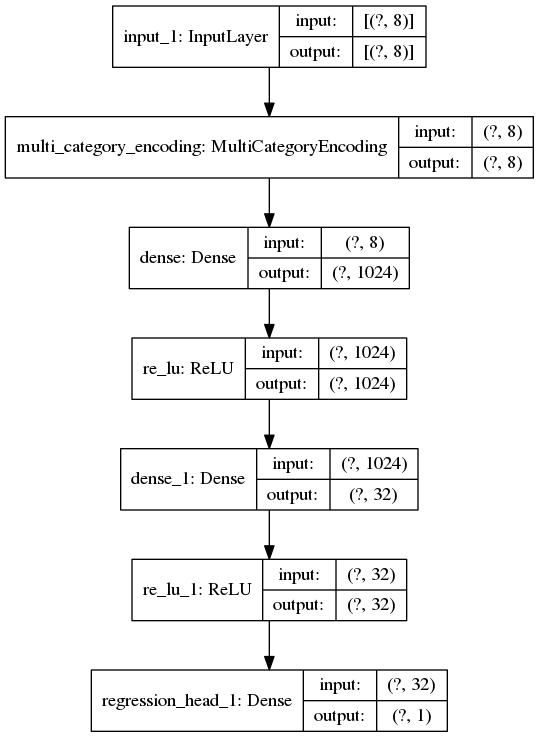

In [14]:
best_model = auto_model.export_model()
tf.keras.utils.plot_model(best_model, show_shapes=True, expand_nested=True) # rankdir='LR'

In [15]:
test_loss, test_acc = auto_model.evaluate(test_data, test_targets, verbose=0)
print('Test accuracy: ', test_acc)

Test accuracy:  1.0389151573181152


## Reference
[ImageClassifier](/image_classifier),
[AutoModel](/auto_model/#automodel-class),
[ImageBlock](/block/#imageblock-class),
[Normalization](/preprocessor/#normalization-class),
[ImageAugmentation](/preprocessor/#image-augmentation-class),
[ResNetBlock](/block/#resnetblock-class),
[ImageInput](/node/#imageinput-class),
[ClassificationHead](/head/#classificationhead-class).